# 

# Detailed Example of Variable Selection Using sdg4varselect

This is a example on how sdg4varselect works on a pharmacodynamic model.

`sdg4varselect` depends on `jax` library but also from `parametrization_cookbook`, this is not mandatory but strongly recommended all the examples will use a specific parametrization.

Let's start by importing all dependencies and the package :

In [2]:
import numpy as np

import jax.numpy as jnp
import jax.random as jrd

import functools
from jax import jit

import parametrization_cookbook.jax as pc
import sdg4varselect.plotting as sdgplt

### Mixed Effects Model Specification

We consider in this example the two compartments pharmacodynamic model used by Pinheiro and Bates (2000). The observation $Y_{i,j}$ is the serum concentration measured at time $t_{i,j}$. The model is given by:
$$Y_{ij} = \dfrac{D k_{ai}}{\mathcal V(k_{ai} - Cl_i)} 
\left( \exp\left(-\dfrac{Cl_i}{\mathcal V} t_{ij}\right) - \exp\left(-k_{ai} t_{ij}\right) \right) + \varepsilon_{ij}, ~
\varepsilon_{ij} \sim \mathcal N(0, \sigma^2).
$$
Where the individual’s parameters $V_i$ represents the distribution volume, $k_{ai}$ the absorption rate,  $Cl_i$  the clearance and $Cl_i/V_i$ the elimination rate; $D_i$ is the known dose of the drug received by individual  $i$.

Let define the individuals parameter using covariates to explain the individual variability : 
$$k_{ai} = \mu_1 +  X_i \beta_1+ \varphi_1,$$
$$Cl_i= \mu_2 +  X_i \beta_2 + \varphi_2,$$
where 
$$\varphi_i \sim \mathcal N_2\left(0, 
\begin{pmatrix}
\omega_1^2 & 0 \\
0 & \omega_2^2
\end{pmatrix}
\right),$$
We also define the non linear function $m$ that define the mixed model : 
$$
    m(t_{ij},V_i, k_{ai}, Cl_i) = \frac{D_i k_{ai}}{V_i(k_{ai} - Cl_i/V_i)} \left(\exp(-k_{ai}t_{ij}) - \exp\left(-\frac{Cl_i}{V_i}t_{ij}\right)\right).
$$

We define this function in the following code : 

In [3]:
def m(params, times, D, V, ka, Cl, **kwargs):
    out = (
        D
        * ka[:, None]
        / (V * ka[:, None] - Cl[:, None])
        * (jnp.exp(-Cl[:, None] / V * times) - jnp.exp(-ka[:, None] * times))
    )

    assert out.shape == times.shape
    return out

Then, we define the individuals parameters with the function : 

In [4]:
def individual_parameters(self, params, **kwargs) -> jnp.ndarray:
    cov1 = kwargs["cov1"]
    cov2 = kwargs["cov2"]

    mean = jnp.array([params.mean_latent.mu1, params.mean_latent.mu2])
    return mean + jnp.array([cov1 @ params.beta1, cov2 @ params.beta2]).T

We can now define our models as follows. We define a new python class inherited from the `AbstractMixedEffectsModel` class. This implements the minimal structure to define a model from only the function that we have just implemented.

We also want to define a high dimensional covariate model, we inherit from the `AbstractHDModel` class for this.

This model is defined with two individual parameters, so we specify them when initialising the class.

In [5]:
from sdg4varselect.models import AbstractMixedEffectsModel, AbstractHDModel


class PKMixedEffectsModel(AbstractMixedEffectsModel, AbstractHDModel):
    def __init__(self, N=1, P=1, **kwargs):
        AbstractHDModel.__init__(self, P=P)
        AbstractMixedEffectsModel.__init__(self, N=N, J=12, **kwargs)
        self.add_latent_variables("ka")
        self.add_latent_variables("Cl")

    @property
    def name(self):
        return f"PKMEM_N{self.N}_J{self.J}_P{self.P}"

    def init_parametrization(self):
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.NamedTuple(
                mu1=pc.Real(loc=10, scale=1),
                mu2=pc.Real(loc=10, scale=1),
            ),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=1),
            var_residual=pc.RealPositive(scale=0.01),
            beta1=pc.Real(scale=1, shape=(self.P // 2,)),
            beta2=pc.Real(scale=1, shape=(self.P // 2,)),
        )
        self.parametrization_size = self._parametrization.size

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def get_mean_latent(self, params, **kwargs) -> jnp.ndarray:
        return individual_parameters(self, params, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        (prngkey_cov, prngkey_mem) = jrd.split(prngkey, num=2)

        time = jnp.array([0.05, 0.15, 0.25, 0.4, 0.5, 0.8, 1, 2, 7, 12, 24, 40])
        self._j = time.shape[0]
        time = jnp.tile(time, (self.N, 1))

        cov = jrd.bernoulli(prngkey_cov, p=0.2, shape=(self.N, self.P // 2))
        cov /= jnp.std(cov, axis=0)[None, :]
        cov -= jnp.mean(cov, axis=0)[None, :]

        obs, sim = AbstractMixedEffectsModel.sample(
            self,
            params_star,
            prngkey_mem,
            mem_obs_time=time,
            cov1=cov,
            cov2=cov[:, :],
        )

        return {"mem_obs_time": time, "cov1": cov, "cov2": cov[:, :]} | obs, sim

### Data Generation

Let's generate a dataset with $300$ individuals, and define the true values ​​of the parameters.

In [6]:
myModel = PKMixedEffectsModel(N=300, P=500 * 2, D=100, V=30)

beta_star = (
    jnp.zeros(shape=(2, myModel.P // 2))
    .at[:, :5]  #
    .set([[3, 2, 1, 0, 0], [0, 0, 3, 2, 1]])  #
)

p_star = myModel.new_params(
    mean_latent={"mu1": 6, "mu2": 8},
    cov_latent=jnp.diag(jnp.array([0.2, 0.1])),
    var_residual=1e-3,
    beta1=beta_star[0, :],
    beta2=beta_star[1, :],
)
# Parameter names for future charts
p_names = np.array(
    ["$\\mu_1$", "$\\mu_2$"]
    + [f"$\\omega^2_{{{i//(2)},{i%(2)}}}$" for i in range(2**2)]
    + ["$\\sigma^2$"]
    + [f"$\\beta_{{1,{i}}}$" for i in range(myModel.P // 2)]
    + [f"$\\beta_{{2,{i}}}$" for i in range(myModel.P // 2)],
)

Then we can generate a data set :

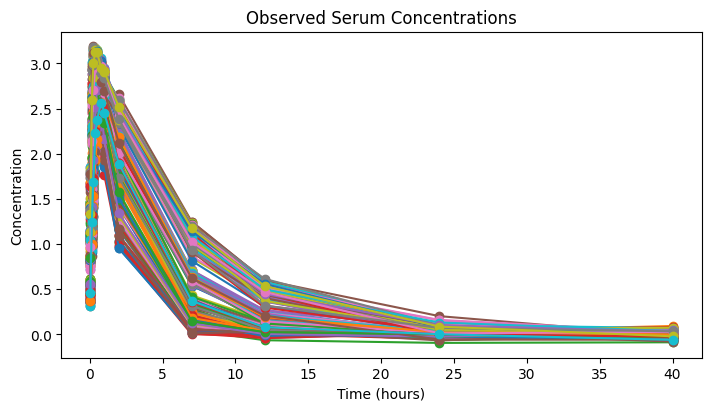

In [7]:
myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))
ax = sdgplt.ax(4, 7)
ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, "o-")
ax.set_title("Observed Serum Concentrations")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Concentration")
ax.figure.savefig("examples/plot/readme_serum_concentration.png", dpi=300)

# Variable Selection Procedure

In order to perform variable selection on the covariates and an estimation of the parameter, we use the Stochastic Proximal Gradient Descent using adaptive stepsize define by the Adagrad algorithm.

In [8]:
from sdg4varselect.algo import (
    preconditioner_factory,
    StochasticProximalGradientDescentPrecond as SPGD,
)

AdaGrad = preconditioner_factory("AdaGrad", scale=None, regularization=1e-8)

algo = SPGD(AdaGrad, partial_fit=False, save_all=False)
algo.init_mcmc(myModel, adaptative_sd=True)

algo.max_iter = 5000
algo.estimate_average_length = 1000

We finally define a function which, for a random seed and a regularization value, performs a selection of the most relevant covariates and then a re-estimation in the model reduced to the selected covariates.

In [9]:
def selection(algo, prngkey, model, data, lbd):
    prngkey_theta, prngkey_select = jrd.split(prngkey, 2)

    # drawing of a random initial value
    theta0 = jrd.normal(prngkey_theta, shape=(model.parametrization.size,))

    algo.set_seed(prngkey_select)
    algo.lbd = lbd  # set the regularization parameter
    out = algo.fit(model, data, theta0)

    return out

We evaluate this function on a grid of regularization values ​​using the function provided by the package. We thus construct a regularization path.

In [10]:
# from sdg4varselect._regularization_function import regularization_path

# regPath = regularization_path(
#     selection,
#     prngkey=jrd.PRNGKey(0),
#     lbd_set=jnp.logspace(1.5, 2.6, num=10),
#     algo=algo,
#     model=myModel,
#     data=myobs,
# )
# regPath.theta_star = p_star
# regPath.save("readme_results")

from sdg4varselect.outputs import RegularizationPath

regPath = RegularizationPath.load("readme_results")

readme_results LOADED !


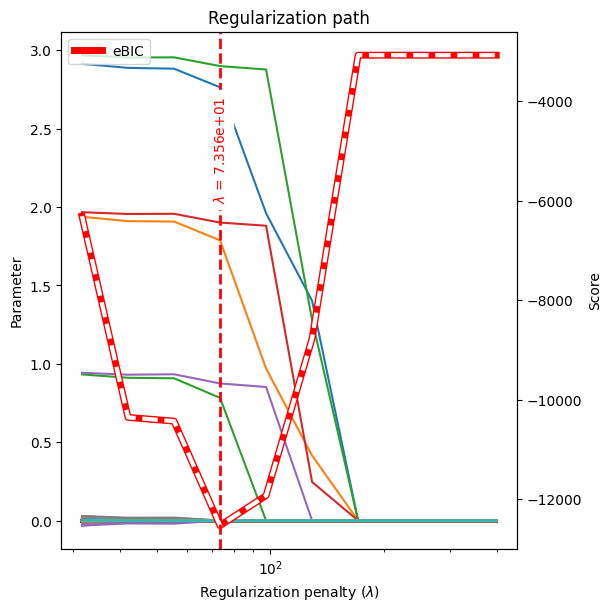

In [11]:
fig = sdgplt.figure(6, 6)
fig = sdgplt.plot_regpath(regPath.standardize(), P=myModel.P, fig=fig)
_ = fig.axes[1].legend(loc="best")
fig.savefig("examples/plot/readme_regpath.png", dpi=300)

We extract the values ​​from the regression vector $(\beta_1, \beta_2)$ then we check the variables that were selected.

In [12]:
beta_estim = regPath.last_theta[jnp.argmin(regPath.ebic), -myModel.P :]
print(f"number of selected variables: {jnp.sum(beta_estim != 0)}")
print(f"non zero coefficients: {beta_estim[beta_estim != 0]}")

number of selected variables: 7
non zero coefficients: [2.76353115e+00 1.78738583e+00 7.82655257e-01 2.89870203e+00
 1.90075391e+00 8.74456940e-01 5.55777709e-08]


The non-zero parameters are well selected in addition to one component, but whose estimate is very low. In this situation, we advise refining the regularization grid in order to find a smaller value of the eBic

## Reestimation in the Reduced Model

We can now reduce the model by selecting variables and making an estimation in the reduced model.

In [21]:
supp = jnp.where(beta_estim != 0)[0]
supp = jnp.unique(supp - jnp.zeros_like(supp).at[3:].set(500))
print(f"The indices of the selected covariates are: {supp}")
myobs["cov1"] = myobs["cov1"][:, supp]
myobs["cov2"] = myobs["cov2"][:, supp]
myReducedModel = PKMixedEffectsModel(N=300, P=len(supp) * 2, D=100, V=30)

p_names = np.array(
    ["$\\mu_1$", "$\\mu_2$"]
    + [f"$\\omega^2_{{{i//(2)},{i%(2)}}}$" for i in range(2**2)]
    + ["$\\sigma^2$"]
    + [f"$\\beta_{{1,{i}}}$" for i in supp]
    + [f"$\\beta_{{2,{i}}}$" for i in supp],
)

The indices of the selected covariates are: [  0   1   2   3   4 467]


In [27]:
AdaGrad = preconditioner_factory("AdaGrad", scale=None, regularization=1e-8)

algo = SPGD(AdaGrad, partial_fit=False)
algo.init_mcmc(myReducedModel, adaptative_sd=True)

algo.max_iter = 5000
algo.estimate_average_length = 4500

In [15]:
def estimation(algo, prngkey, model, data):
    prngkey_theta, prngkey_estim = jrd.split(prngkey, 2)

    # drawing of a random initial value
    theta0 = jrd.normal(prngkey_theta, shape=(model.parametrization.size,))

    algo.set_seed(prngkey_estim)
    algo.lbd = None  # unset the regularization parameter for un penalized estimation
    return algo.fit(model, data, theta0)

To plot the estimates during the iterations, we need to enable saving of all algorithm data

In [16]:
algo.save_all = True

In [28]:
from sdg4varselect.outputs import MultiGDResults

allEstim = MultiGDResults(
    results=[estimation(algo, jrd.PRNGKey(i), myReducedModel, myobs) for i in range(5)]
)
allEstim.theta_star = myReducedModel.new_params(
    mean_latent={"mu1": 6, "mu2": 8},
    cov_latent=jnp.diag(jnp.array([0.2, 0.1])),
    var_residual=1e-3,
    beta1=beta_star[0, supp],
    beta2=beta_star[1, supp],
)

allEstim.save("readme_estimations")

Stopping at step 2022 because of breaking rules
Stopping at step 1587 because of breaking rules
Stopping at step 2234 because of breaking rules
Stopping at step 2514 because of breaking rules
Stopping at step 1706 because of breaking rules
readme_estimations SAVED !


We can observe and verify the good convergence of the algorithm

/home/acaillebotte/projects/packages/sdg4varselect/sdg4varselect/outputs.py:503: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left")


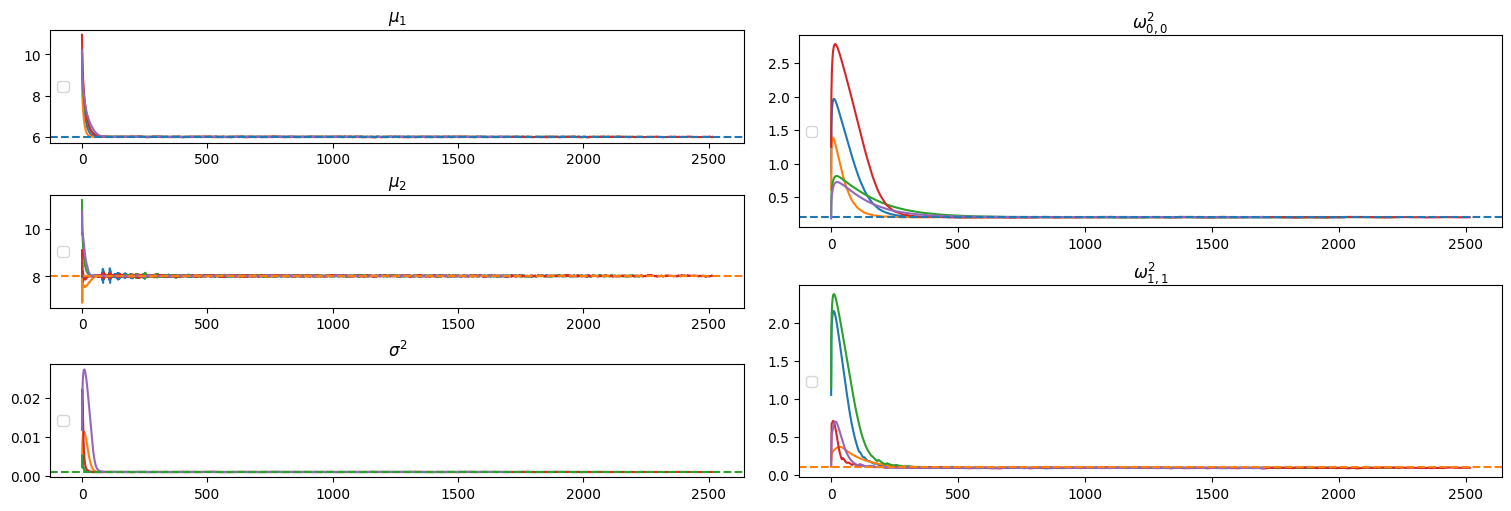

In [29]:
fig = sdgplt.figure(5, 15)
_ = sdgplt.plot_theta(
    allEstim,
    fig=[*fig.subfigures(1, 2)],
    params_names=p_names,
    id_to_plot=[
        [0, 1, 6],
        [2, 5],  # 3, 4,
    ],
    log_scale=False,
)
fig.savefig("examples/plot/readme_estim_ld.png", dpi=300)

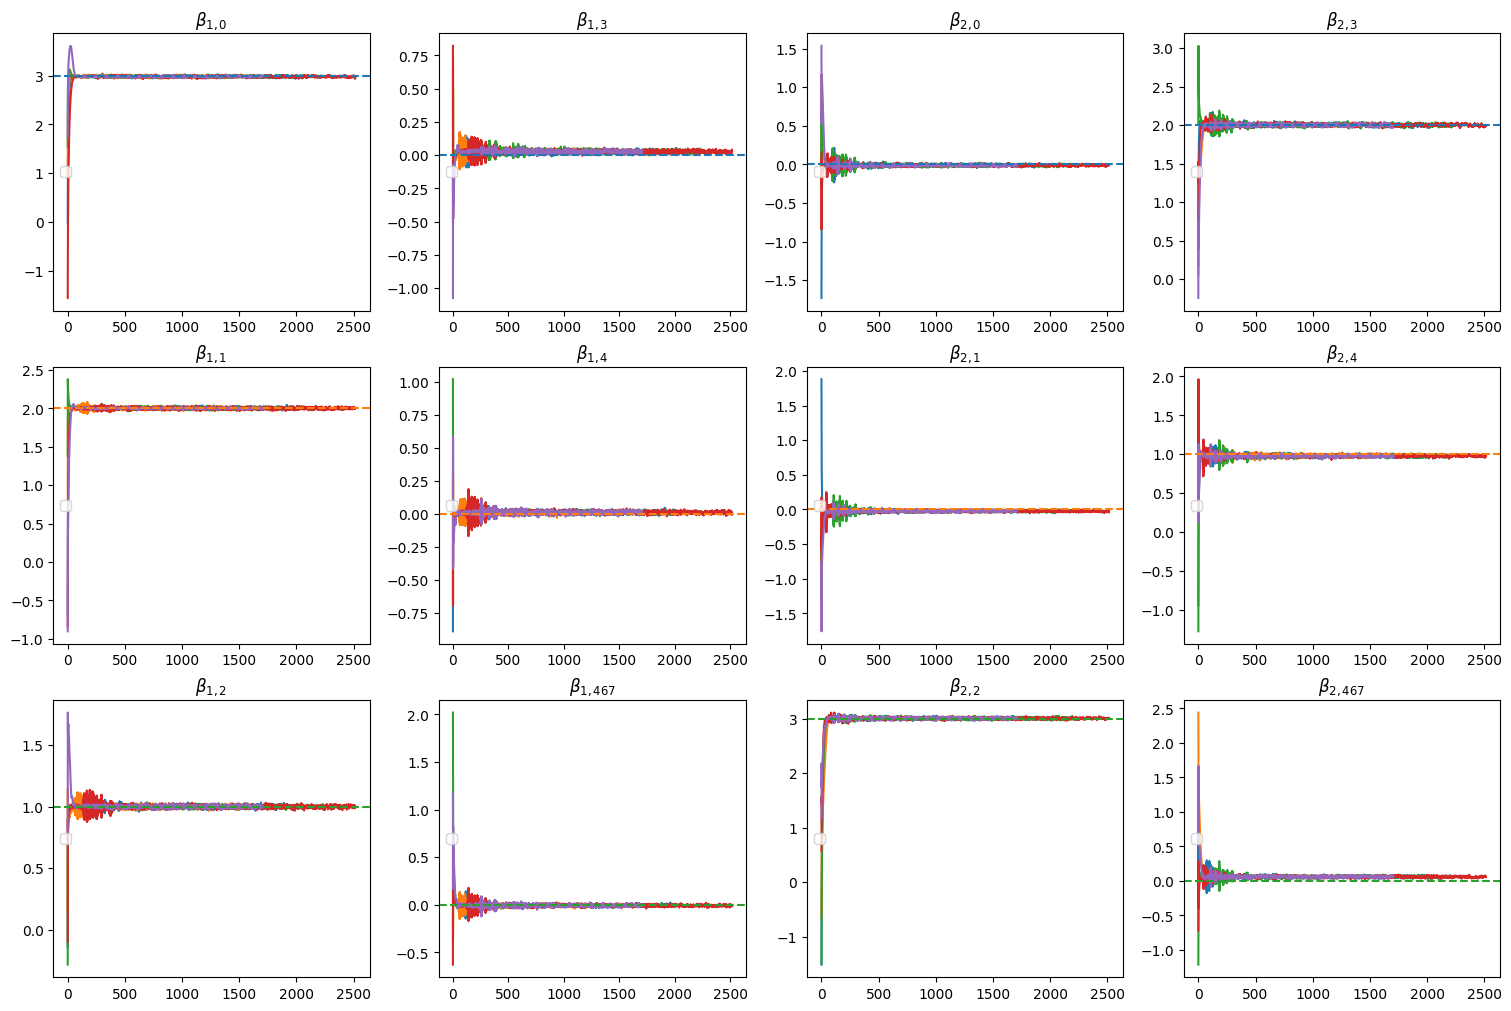

In [24]:
fig = sdgplt.figure(10, 15)
_ = sdgplt.plot_theta(
    allEstim,
    fig=[*fig.subfigures(1, 4)],
    params_names=p_names,
    id_to_plot=[
        [7, 8, 9],
        [10, 11, 12],
        [13, 14, 15],
        [16, 17, 18],
    ],
    log_scale=False,
)
fig.savefig("examples/plot/readme_estim_hd.png", dpi=300)